In [1]:
from zipfile import ZipFile
file_name = "/content/PlantVillage.zip"
with ZipFile(file_name, "r") as zip:
  zip.extractall()
  print("Done")

Done


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

Import data into tensorflow dataset object

In [4]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [5]:
class_name = df.class_names
class_name

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [6]:
for image_batch, labels_batch in df.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 2 2 0 2 1 2 2 2 2 1 1 2 1 1 1 0 1 1 0 0 1 0 1 1 2 0 1 1 1]


Visualize some of the images from our dataset

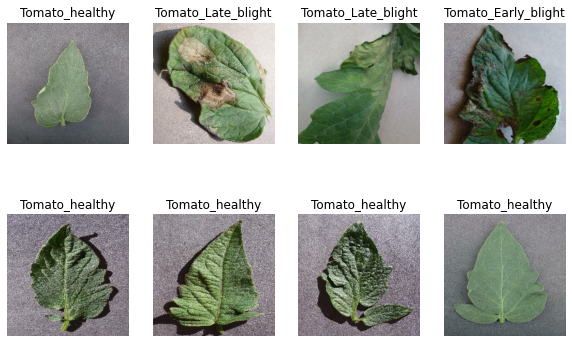

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in df.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset

In [15]:
len(df)

141

In [16]:
train_size = 0.8
len(df)*train_size

112.80000000000001

In [17]:
train_df = df.take(112)
len(train_ds)

112

In [18]:
test_df = df.skip(112)
len(test_df)

29

In [19]:
val_size=0.1
len(df)*val_size

14.100000000000001

In [20]:
val_df = test_ds.take(14)
len(val_df)

14

In [21]:
test_df = test_df.skip(14)
len(test_df)

15

In [28]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [29]:
train_df, val_df, test_df = get_dataset_partitions_tf(df)

In [30]:
len(train_df)

112

In [31]:
len(val_df)

14

In [32]:
len(test_df)

15

Cache, Shuffle, and Prefetch the Dataset

In [34]:
train_ds = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model

Creating a Layer for Resizing and Normalization

In [35]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation

In [36]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [37]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture

We use a CNN coupled with a Softmax activation in the output layer

In [38]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [40]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
112/112 [==============================] - 450s 4s/step - loss: 0.6834 - accuracy: 0.6764 - val_loss: 0.5086 - val_accuracy: 0.7857
Epoch 2/20
112/112 [==============================] - 433s 4s/step - loss: 0.4090 - accuracy: 0.8273 - val_loss: 0.4722 - val_accuracy: 0.8058
Epoch 3/20
112/112 [==============================] - 432s 4s/step - loss: 0.3112 - accuracy: 0.8746 - val_loss: 0.6323 - val_accuracy: 0.7679
Epoch 4/20
112/112 [==============================] - 430s 4s/step - loss: 0.2947 - accuracy: 0.8765 - val_loss: 0.2835 - val_accuracy: 0.8817
Epoch 5/20
112/112 [==============================] - 431s 4s/step - loss: 0.2899 - accuracy: 0.8819 - val_loss: 0.3017 - val_accuracy: 0.8661
Epoch 6/20
112/112 [==============================] - 431s 4s/step - loss: 0.2798 - accuracy: 0.8897 - val_loss: 0.5651 - val_accuracy: 0.7812
Epoch 7/20
112/112 [==============================] - 430s 4s/step - loss: 0.2532 - accuracy: 0.8992 - val_loss: 0.2759 - val_accuracy: 0.8884

In [42]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 27s 1s/step - loss: 0.1698 - accuracy: 0.9292


In [43]:
scores

[0.1697784811258316, 0.9291666746139526]

Plotting the Accuracy and Loss Curves

In [44]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 112}

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
type(history.history['loss'])

list

In [47]:

len(history.history['loss'])

20

In [48]:
history.history['loss'][:10]

[0.6833710670471191,
 0.4089798033237457,
 0.31118884682655334,
 0.29467639327049255,
 0.28991395235061646,
 0.2797515094280243,
 0.2532331943511963,
 0.2844921350479126,
 0.22915634512901306,
 0.2354995757341385]

In [49]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

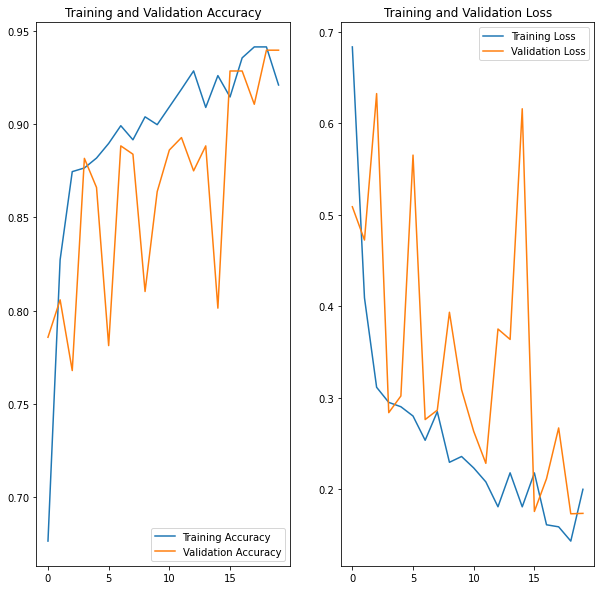

In [51]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction sample image

first image to predict
actual label: Tomato_Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Tomato_Late_blight


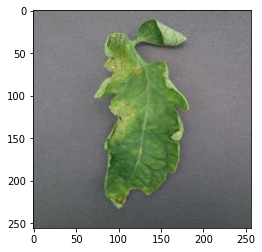

In [54]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [56]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 70ms/step


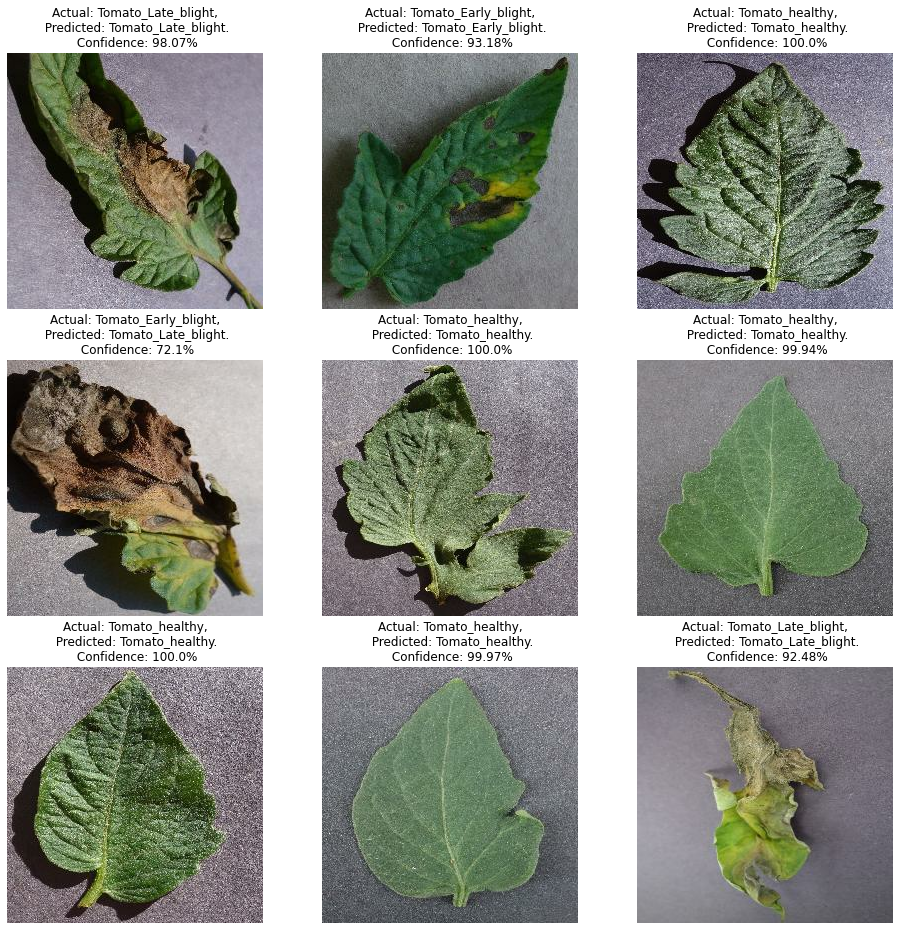

In [62]:
plt.figure(figsize=(16, 16))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Save model

In [59]:
model.save("Tomato.h5")